In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# from ipynb.fs.full.Functions import factorial

RANDOM_SEED = 1235846    # Set a random seed for reproducibility!

In [303]:
def model_predictions(model, x_train, y_train, x_test=None, y_test=None):

    '''Enter model name and test/train sets to generate predictions, precision, recall, accuracy, and F1 score'''
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    if x_test:
        y_hat_test = model.predict(x_test)
    print('Training Precision: ', precision_score(y_train, y_hat_train))
    if x_test:
        print('Testing Precision: ', precision_score(y_test, y_hat_test))
    print('-----')

    print('Training Recall: ', recall_score(y_train, y_hat_train))
    if x_test:
        print('Testing Recall: ', recall_score(y_test, y_hat_test))
    print('-----')

    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    if x_test:
        print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
    print('-----')

    print('Training F1-Score: ', f1_score(y_train, y_hat_train))
    if x_test:
        print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

In [ ]:
def preprocessing(train_dataset):
    #clearing nulls
    train_dataset_mod = train_dataset.copy()
    if train_dataset.isna().sum().sum() > 0:
        for col in train_dataset.columns.copy():
            if train_dataset_mod[col].dtypes == float:
                train_dataset_mod[col].fillna(np.mean(train_dataset[col]), inplace=True)
            else:
                train_dataset_mod[col].fillna(train_dataset[col].value_counts().keys()[0], inplace=True)
                
    #creating a correlation to see if any columns are highly correlated with each other
    corr = train_dataset_mod.corr()
    #lower half of a heatmap process
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(11,9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    #creating dummies for all of the categorical variables so that everything is in terms of 0 and 1 now
    train_dataset_mod = pd.get_dummies(train_dataset_mod, drop_first=True)
    #since our X and y datasets is already split into two separate datasets, there won't be a train/test split
    #since all of the features are binary of 0 and 1, no normalization will be needed
    return train_dataset_mod

In [2]:
features_df = pd.read_csv('./data/flu_training_set_features.csv', index_col='respondent_id')
labels_df = labels_df = pd.read_csv("./data/flu_training_set_labels.csv", index_col="respondent_id")

In [3]:
features_df.shape

(26707, 35)

In [4]:
df_comp = features_df.join(labels_df)

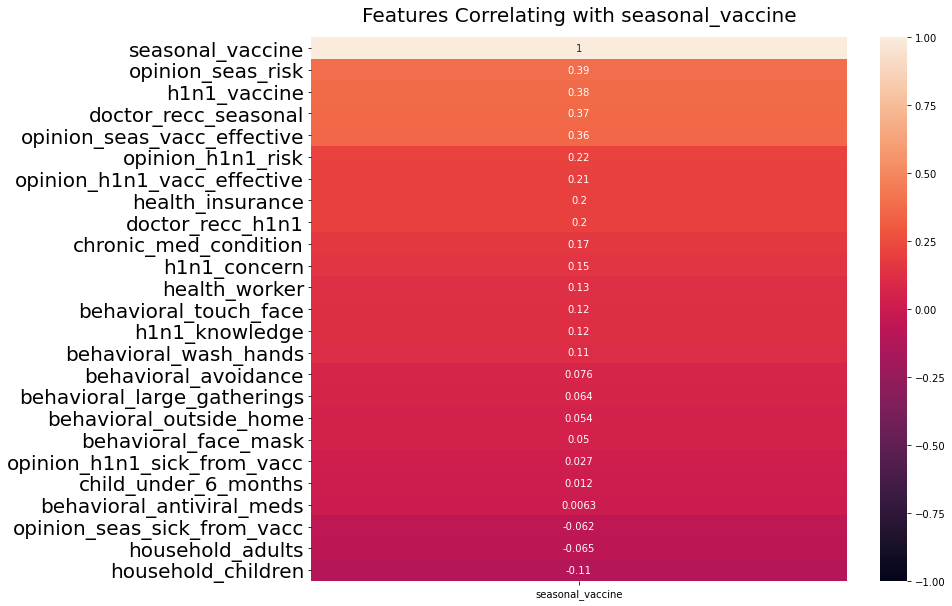

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df_comp.corr()[['seasonal_vaccine']].sort_values(by='seasonal_vaccine', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with seasonal_vaccine', fontdict={'fontsize':20}, pad=16)
plt.yticks(fontsize=20);
# plt.savefig('correlation_price_1', bbox_inches='tight')

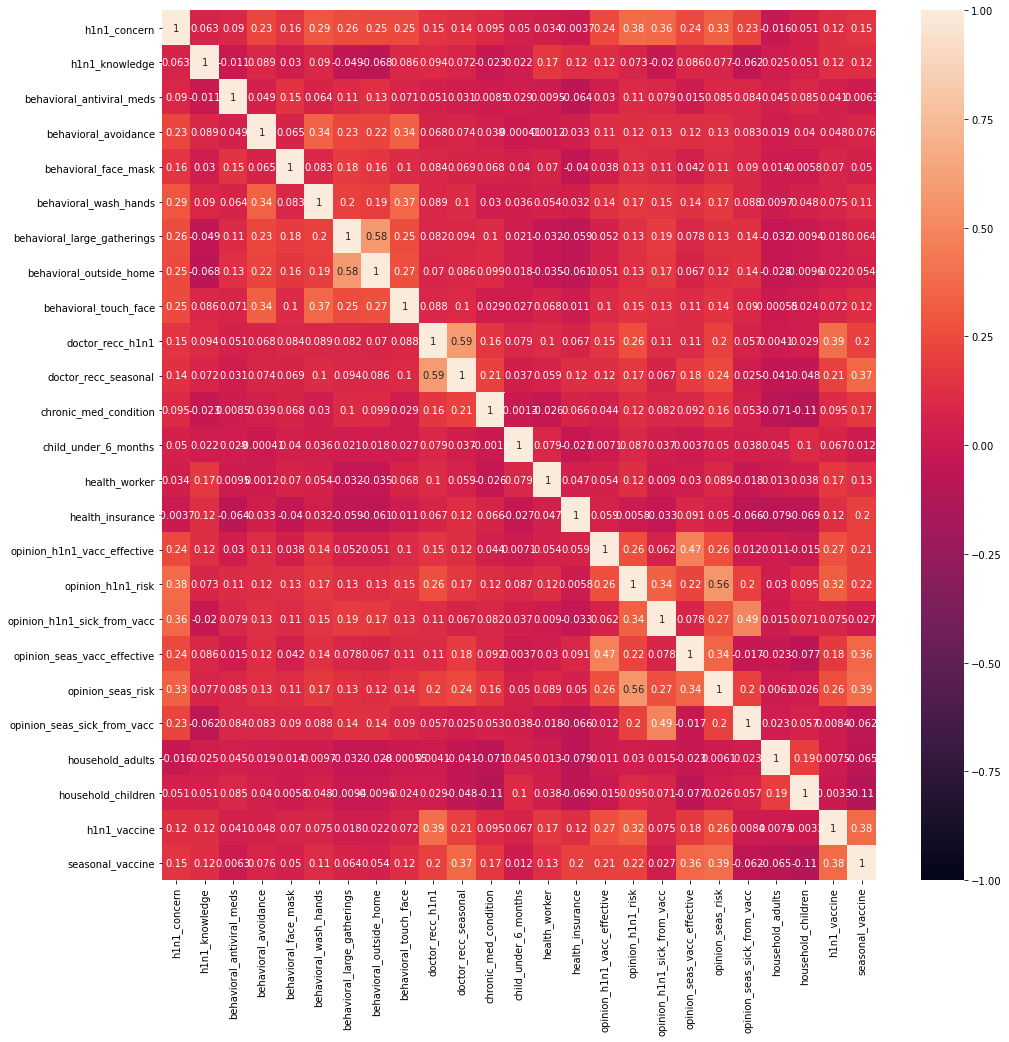

In [6]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df_comp.corr(), vmin=-1, vmax=1, annot=True);

In [7]:
labels_df.drop('h1n1_vaccine', axis=1, inplace=True)

In [8]:
labels_df.value_counts()

seasonal_vaccine
0                   14272
1                   12435
dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=0.25,
    random_state=RANDOM_SEED
)

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 22707 to 3101
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 19956 non-null  float64
 1   h1n1_knowledge               19940 non-null  float64
 2   behavioral_antiviral_meds    19980 non-null  float64
 3   behavioral_avoidance         19870 non-null  float64
 4   behavioral_face_mask         20014 non-null  float64
 5   behavioral_wash_hands        19993 non-null  float64
 6   behavioral_large_gatherings  19957 non-null  float64
 7   behavioral_outside_home      19962 non-null  float64
 8   behavioral_touch_face        19931 non-null  float64
 9   doctor_recc_h1n1             18430 non-null  float64
 10  doctor_recc_seasonal         18430 non-null  float64
 11  chronic_med_condition        19320 non-null  float64
 12  child_under_6_months         19421 non-null  float64
 13  health_worker

In [11]:
numeric_col = [col for col in X_train.columns if X_train[col].dtype != 'O']
categorical_col  = [col for col in X_train.columns if X_train[col].dtype == 'O']

In [12]:
X_train_num = X_train[numeric_col].copy()
X_train_cat = X_train[categorical_col].copy()
X_test_num = X_test[numeric_col].copy()
X_test_cat = X_test[categorical_col].copy()

In [13]:
X_train_cat

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
22707,55 - 64 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,oxchjgsf,"MSA, Not Principle City",xqicxuve,uqqtjvyb
1882,55 - 64 Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,kbazzjca,Non-MSA,NaN,NaN
10493,45 - 54 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,bhuqouqj,Non-MSA,wxleyezf,xtkaffoo
5614,45 - 54 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,mlyzmhmf,"MSA, Principle City",NaN,NaN
23905,45 - 54 Years,College Graduate,White,Female,"> $75,000",Not Married,Own,Employed,bhuqouqj,"MSA, Principle City",fcxhlnwr,xtkaffoo
...,...,...,...,...,...,...,...,...,...,...,...,...
24330,45 - 54 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,mlyzmhmf,"MSA, Principle City",ldnlellj,mxkfnird
18930,55 - 64 Years,College Graduate,Black,Female,"> $75,000",Married,Rent,Not in Labor Force,kbazzjca,Non-MSA,NaN,NaN
20037,45 - 54 Years,College Graduate,White,Female,"> $75,000",Married,Own,Employed,mlyzmhmf,Non-MSA,fcxhlnwr,mxkfnird


In [14]:
X_train_cat.age_group.isna().value_counts()

False    20030
Name: age_group, dtype: int64

In [15]:
X_train_cat.education.isna().value_counts()

False    18997
True      1033
Name: education, dtype: int64

In [16]:
X_train_cat.race.isna().value_counts()

False    20030
Name: race, dtype: int64

In [17]:
X_train_cat.sex.isna().value_counts()

False    20030
Name: sex, dtype: int64

In [18]:
X_train_cat.income_poverty.isna().value_counts()

False    16725
True      3305
Name: income_poverty, dtype: int64

In [19]:
X_train_cat.marital_status.isna().value_counts()

False    19004
True      1026
Name: marital_status, dtype: int64

In [20]:
X_train_cat.rent_or_own.isna().value_counts()

False    18503
True      1527
Name: rent_or_own, dtype: int64

In [21]:
X_train_cat.employment_status.isna().value_counts()

False    18955
True      1075
Name: employment_status, dtype: int64

In [22]:
X_train_cat.census_msa.isna().value_counts()

False    20030
Name: census_msa, dtype: int64

In [23]:
X_train_cat.drop(['hhs_geo_region', 'employment_industry', 'employment_occupation'], axis=1, inplace=True) # No data
X_test_cat.drop(['hhs_geo_region', 'employment_industry', 'employment_occupation'], axis=1, inplace=True) # No data

In [24]:
X_train_cat.education.fillna(value='Unknown', inplace=True)
X_train_cat.income_poverty.fillna(value='Unknown', inplace=True)
X_train_cat.marital_status.fillna(value='Unknown', inplace=True)
X_train_cat.rent_or_own.fillna(value='Unknown', inplace=True)
X_train_cat.employment_status.fillna(value='Unknown', inplace=True)

X_test_cat.education.fillna(value='Unknown', inplace=True)
X_test_cat.income_poverty.fillna(value='Unknown', inplace=True)
X_test_cat.marital_status.fillna(value='Unknown', inplace=True)
X_test_cat.rent_or_own.fillna(value='Unknown', inplace=True)
X_test_cat.employment_status.fillna(value='Unknown', inplace=True)

In [25]:
X_train_cat

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa
respondent_id,,,,,,,,,
22707,55 - 64 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,"MSA, Not Principle City"
1882,55 - 64 Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,Non-MSA
10493,45 - 54 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,Non-MSA
5614,45 - 54 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,"MSA, Principle City"
23905,45 - 54 Years,College Graduate,White,Female,"> $75,000",Not Married,Own,Employed,"MSA, Principle City"
...,...,...,...,...,...,...,...,...,...
24330,45 - 54 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Principle City"
18930,55 - 64 Years,College Graduate,Black,Female,"> $75,000",Married,Rent,Not in Labor Force,Non-MSA
20037,45 - 54 Years,College Graduate,White,Female,"> $75,000",Married,Own,Employed,Non-MSA


In [26]:
X_train_num.isna().sum()

h1n1_concern                     74
h1n1_knowledge                   90
behavioral_antiviral_meds        50
behavioral_avoidance            160
behavioral_face_mask             16
behavioral_wash_hands            37
behavioral_large_gatherings      73
behavioral_outside_home          68
behavioral_touch_face            99
doctor_recc_h1n1               1600
doctor_recc_seasonal           1600
chronic_med_condition           710
child_under_6_months            609
health_worker                   599
health_insurance               9271
opinion_h1n1_vacc_effective     290
opinion_h1n1_risk               293
opinion_h1n1_sick_from_vacc     302
opinion_seas_vacc_effective     349
opinion_seas_risk               391
opinion_seas_sick_from_vacc     407
household_adults                180
household_children              180
dtype: int64

In [27]:
X_train_num = X_train_num.fillna(X_train_num.mode().iloc[0])
X_test_num = X_test_num.fillna(X_train_num.mode().iloc[0])

In [28]:
X_train_num.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
dtype: int64

In [29]:
X_train_cat

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa
respondent_id,,,,,,,,,
22707,55 - 64 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,"MSA, Not Principle City"
1882,55 - 64 Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,Non-MSA
10493,45 - 54 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,Non-MSA
5614,45 - 54 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,"MSA, Principle City"
23905,45 - 54 Years,College Graduate,White,Female,"> $75,000",Not Married,Own,Employed,"MSA, Principle City"
...,...,...,...,...,...,...,...,...,...
24330,45 - 54 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Principle City"
18930,55 - 64 Years,College Graduate,Black,Female,"> $75,000",Married,Rent,Not in Labor Force,Non-MSA
20037,45 - 54 Years,College Graduate,White,Female,"> $75,000",Married,Own,Employed,Non-MSA


In [30]:
# Make dummies for all Cat features
X_train_dummies = pd.get_dummies(X_train_cat, drop_first=True)
X_test_dummies = pd.get_dummies(X_test_cat, drop_first=True)
X_train_dummies

,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,education_Unknown,race_Hispanic,race_Other or Multiple,...,income_poverty_Unknown,marital_status_Not Married,marital_status_Unknown,rent_or_own_Rent,rent_or_own_Unknown,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_Unknown,"census_msa_MSA, Principle City",census_msa_Non-MSA
respondent_id,,,,,,,,,,,,,,,,,,,,,
22707,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1882,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10493,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5614,0,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
23905,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24330,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
18930,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
20037,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
X_train_cat = X_train_cat.fillna(X_train_cat.mode().iloc[0])

In [32]:
X_train_num = X_train_num.fillna(X_train_num.mode().iloc[0])

In [35]:
# Make dummies for all Cat features
X_train_dummies = pd.get_dummies(X_train_cat, drop_first=True)

In [36]:
X_train_dummies = X_train_dummies.sort_values('respondent_id')
X_train_dummies

,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,education_Unknown,race_Hispanic,race_Other or Multiple,...,income_poverty_Unknown,marital_status_Not Married,marital_status_Unknown,rent_or_own_Rent,rent_or_own_Unknown,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_Unknown,"census_msa_MSA, Principle City",census_msa_Non-MSA
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26701,0,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
26702,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
26704,0,0,1,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,1,0,0


In [37]:
X_train_num.fillna(value=0, inplace=True)

In [41]:
from sklearn.impute import SimpleImputer
si = SimpleImputer()

In [42]:
X_train_num = si.fit_transform(X_train_num)
X_train_num = pd.DataFrame(X_train_num, columns=X_train[numeric_col].columns)

In [43]:
X_train_num.set_index(X_train_dummies.index, inplace=True)

In [44]:
X_train_comp = X_train_dummies.join(X_train_num)
X_test_comp = X_test_dummies.join(X_test_num)

In [45]:
X_test_comp

,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_< 12 Years,education_College Graduate,education_Some College,education_Unknown,race_Hispanic,race_Other or Multiple,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
20199,0,0,0,1,0,0,0,0,0,0,...,0.0,1.0,4.0,2.0,1.0,4.0,2.0,2.0,0.0,0.0
4710,0,0,0,0,0,1,0,0,0,0,...,0.0,1.0,5.0,1.0,2.0,5.0,4.0,2.0,2.0,0.0
15446,0,0,0,1,0,1,0,0,0,1,...,0.0,1.0,4.0,2.0,4.0,5.0,4.0,4.0,1.0,0.0
5493,0,0,0,1,0,1,0,0,0,0,...,0.0,1.0,4.0,2.0,4.0,4.0,2.0,4.0,2.0,1.0
22043,1,0,0,0,0,1,0,0,0,0,...,0.0,1.0,4.0,2.0,2.0,4.0,4.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,1,0,0,0,0,0,1,0,0,0,...,0.0,1.0,5.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0
3639,0,0,1,0,0,0,1,0,0,0,...,0.0,1.0,4.0,2.0,2.0,4.0,2.0,1.0,1.0,0.0
703,0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,4.0,4.0,2.0,5.0,2.0,1.0,1.0,0.0


# Simple Logistic Regression

In [46]:
lr = LogisticRegression()

In [47]:
ss = StandardScaler()
X_train_comp_scaled = ss.fit_transform(X_train_comp)
X_test_comp_scaled = ss.transform(X_test_comp)

In [48]:
lr.fit(X_train_comp_scaled, y_train.values.ravel())

LogisticRegression()

In [57]:
prob_hat = lr.predict_proba(X_train_comp_scaled)
y_hat_lr = lr.predict(X_train_comp_scaled)

D:\ProgramFilesD\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


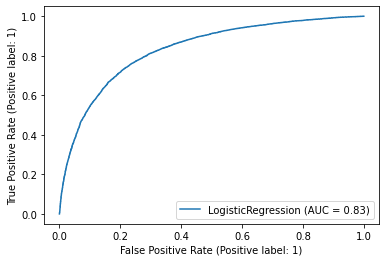

In [58]:
plot_roc_curve(lr, X_train_comp_scaled, y_train.values.ravel());

In [59]:
roc_auc_score(y_train, y_hat_lr)

0.7584486651108674

In [62]:
cm = confusion_matrix(y_train, y_hat_lr)

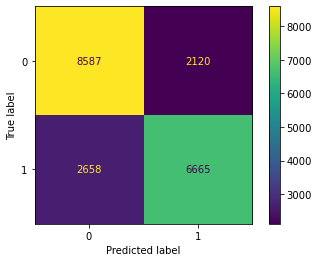

In [64]:
ConfusionMatrixDisplay(cm).plot()

D:\ProgramFilesD\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


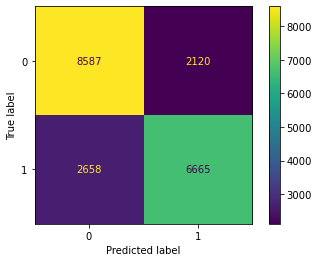

In [53]:
plot_confusion_matrix(lr, X_train_comp_scaled, y_train)

# Simple Decision Tree

In [66]:
dtc = DecisionTreeClassifier(max_depth=10)

In [67]:
dtc.fit(X_train_comp_scaled, y_train)

DecisionTreeClassifier(max_depth=10)

In [69]:
prob_hat_dtc = dtc.predict_proba(X_train_comp_scaled)
y_hat_dtc = dtc.predict(X_train_comp_scaled)

D:\ProgramFilesD\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


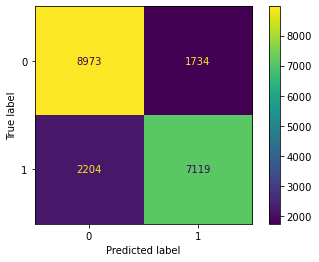

In [70]:
plot_confusion_matrix(dtc, X_train_comp_scaled, y_train)

In [71]:
roc_auc_score(y_train, y_hat_dtc)

0.8008226415586539

In [ ]:
# With test data

In [72]:
y_hat_test_dtc = dtc.predict(X_test_comp_scaled)

In [73]:
roc_auc_score(y_test, y_hat_test_dtc)

0.7422067497845738

D:\ProgramFilesD\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


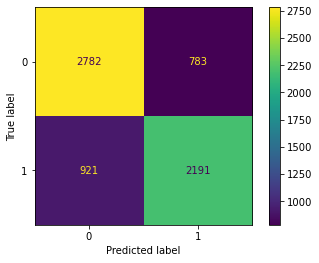

In [74]:
plot_confusion_matrix(dtc, X_test_comp_scaled, y_test)

# Simple KNN

In [76]:
knn = KNeighborsClassifier()

In [77]:
knn.fit(X_train_comp_scaled, y_train.values.ravel())

KNeighborsClassifier()

In [78]:
y_hat_knn = knn.predict(X_train_comp_scaled)

In [79]:
roc_auc_score(y_train, y_hat_knn)

0.7800022331893471

D:\ProgramFilesD\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


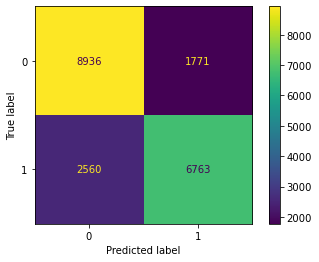

In [80]:
plot_confusion_matrix(knn, X_train_comp_scaled, y_train)

# Simple Naive Bayes

In [323]:
bayes = GaussianNB()

bayes.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_bayes = bayes.predict(X_train_comp_scaled)

model_predictions(bayes, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  0.688607334157396
-----
Training Recall:  0.7170438699989273
-----
Training Accuracy:  0.7173739390913629
-----
Training F1-Score:  0.7025379643739162


In [293]:
# roc_auc_score(y_train, y_hat_baynes)

### Params for Naive Bayes

In [296]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}

gs_NB = GridSearchCV(estimator=bayes, param_grid=params_NB, cv=10)

gs_NB.fit(X_train_comp_scaled, y_train.values.ravel())
gs_NB.best_params_

{'var_smoothing': 1.0}

### Tuned Naive Bayes

In [305]:
bayes_tuned = GaussianNB(var_smoothing=1)

bayes_tuned.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_bayes_tuned = bayes_tuned.predict(X_train_comp_scaled)

model_predictions(bayes, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  0.688607334157396
-----
Training Recall:  0.7170438699989273
-----
Training Accuracy:  0.7173739390913629
-----
Training F1-Score:  0.7025379643739162


# Random Forest

In [307]:
rfc = RandomForestClassifier()

rfc.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_rfc = rfc.predict(X_train_comp_scaled)

model_predictions(rfc, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  1.0
-----
Training Recall:  1.0
-----
Training Accuracy:  1.0
-----
Training F1-Score:  1.0


### Params for Random Forest

In [146]:
params_rfc = {}
params_rfc['criterion'] = ['gini', 'entropy']
params_rfc['min_samples_leaf'] = [1, 5, 10]
params_rfc['max_depth'] = [1, 3, 5, 10, 15]
params_rfc['warm_start'] = [True, False]
params_rfc['ccp_alpha'] = [0, 0.1, 0.5, 1, 2]

In [147]:
gs_rfc = GridSearchCV(estimator=rfc,
                 param_grid=params_rfc,
                 cv=5)

# gs_rfc.fit(X_train_comp_scaled, y_train.values.ravel())
gs_rfc.best_params_

{'ccp_alpha': 0,
 'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 10,
 'warm_start': False}

### Tuned Random Forest

In [314]:
rfc_tuned = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=10, warm_start=False, ccp_alpha=0)

rfc_tuned.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_rfc_tuned = rfc_tuned.predict(X_train_comp_scaled)

model_predictions(rfc_tuned, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  0.7975426167810493
-----
Training Recall:  0.7728199077550145
-----
Training Accuracy:  0.8029455816275587
-----
Training F1-Score:  0.784986653592635


# G Boost

In [315]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_gbc = gbc.predict(X_train_comp_scaled)

model_predictions(gbc, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  0.7641950567802271
-----
Training Recall:  0.7362436983803496
-----
Training Accuracy:  0.7714927608587119
-----
Training F1-Score:  0.7499590275880907


### Params for G Boost

In [166]:
params_gbc = {}
params_gbc['min_samples_leaf'] = [1, 5, 10]
params_gbc['max_depth'] = [1, 3, 5, 10, 15, 20]

In [167]:
gs_gbc = GridSearchCV(estimator=gbc,
                 param_grid=params_gbc,
                 cv=5)
gs_gbc.fit(X_train_comp_scaled, y_train.values.ravel())
gs_gbc.best_params_

{'max_depth': 3, 'min_samples_leaf': 5}

In [316]:
gbc_tuned = GradientBoostingClassifier(max_depth=3, min_samples_leaf=5)

gbc_tuned.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_gbc_tuned = gbc_tuned.predict(X_train_comp_scaled)

model_predictions(gbc_tuned, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  0.7641950567802271
-----
Training Recall:  0.7362436983803496
-----
Training Accuracy:  0.7714927608587119
-----
Training F1-Score:  0.7499590275880907


# Histogram-based Gradient Boosting

In [317]:
hgbc = HistGradientBoostingClassifier()

hgbc.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_hgbc = hgbc.predict(X_train_comp_scaled)

model_predictions(hgbc, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  0.7764417724337564
-----
Training Recall:  0.7480424755979835
-----
Training Accuracy:  0.7824762855716425
-----
Training F1-Score:  0.7619776017481562


### Params for Hist Boost

In [172]:
params_hgbc = {}
params_hgbc['min_samples_leaf'] = [1, 5, 10]
params_hgbc['max_depth'] = [1, 3, 5, 10, 15, 20]

In [173]:
gs_hgbc = GridSearchCV(estimator=hgbc,
                 param_grid=params_hgbc,
                 cv=5)

gs_hgbc.fit(X_train_comp_scaled, y_train.values.ravel())
gs_hgbc.best_params_

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'max_depth': [1, 3, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 5, 10]})

{'max_depth': 15, 'min_samples_leaf': 1}

### Tuned Hist Boost

In [319]:
hgbc_tuned = HistGradientBoostingClassifier(max_depth=15, min_samples_leaf=1)

hgbc_tuned.fit(X_train_comp_scaled, y_train.values.ravel())
y_hat_hgbc_tuned = hgbc_tuned.predict(X_train_comp_scaled)

model_predictions(hgbc_tuned, X_train_comp_scaled, y_train.values.ravel())

Training Precision:  0.7813368924480035
-----
Training Recall:  0.7535128177625228
-----
Training Accuracy:  0.7871193210184723
-----
Training F1-Score:  0.7671726547996068


In [ ]:
hhh

# Pipelines

In [223]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
# The FunctionTransformer will turn my function
# into a transformer.

def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

GrabNumeric = FunctionTransformer(grab_numeric)

In [224]:
pipe = Pipeline(steps=[('num', GrabNumeric),
                       ('ss', StandardScaler())])

In [227]:
pipe.fit(X_train_comp)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x000001197CCE54C0>)),
                ('ss', StandardScaler())])

In [228]:
pipe.transform(X_train_comp)

array([[-1.78815974, -2.0469644 , -0.22583668, ..., -0.82232655,
         0.15176495, -0.56863726],
       [-0.68644213,  1.19753168, -0.22583668, ..., -0.07134854,
         0.15176495, -0.56863726],
       [ 0.41527548, -0.42471636, -0.22583668, ..., -0.07134854,
         1.48796357, -0.56863726],
       ...,
       [ 0.41527548,  1.19753168, -0.22583668, ...,  1.4306075 ,
         0.15176495, -0.56863726],
       [-1.78815974,  1.19753168, -0.22583668, ..., -0.07134854,
         1.48796357, -0.56863726],
       [ 0.41527548,  1.19753168, -0.22583668, ..., -0.82232655,
         0.15176495, -0.56863726]])

In [229]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [230]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [X_train.columns.get_loc(col) for col in X_train.columns if X_train[col].dtype != 'O']),
                                         ('subpipe_cat', subpipe_cat, [X_train.columns.get_loc(col) for col in X_train.columns if X_train[col].dtype == 'O'])],
                           remainder='passthrough')

In [ ]:
# [X_train.columns.get_loc(col) for col in X_train.columns if X_train[col].dtype != 'O']

In [238]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

bayes_model_pipe = Pipeline(steps=[('ct', CT),
                            ('bayes', GaussianNB())])

In [239]:
bayes_model_pipe.fit(X_train_comp, y_train.values.ravel())

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 31, 32]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                

In [240]:
bayes_model_pipe.score(X_train_comp, y_train)

0.7106340489266101

In [255]:

lr_model_pipe = Pipeline(steps=[('ct', CT),
                            ('lr', LogisticRegression())])

# Multiple pipes

In [250]:
rfc_pipeline = Pipeline([
    ('ct', CT),
    ('rfc', RandomForestClassifier())
])

params_rfc = {}
params_rfc['rfc__criterion'] = ['gini', 'entropy']
params_rfc['rfc__min_samples_leaf'] = [1, 5, 10]
params_rfc['rfc__max_depth'] = [3, 15, 25]

clf = GridSearchCV(rfc_pipeline, params_rfc)
clf.fit(X_train_comp, y_train.values.ravel())
# print("Best Score: ", rfc.best_score_)
# print("Best Params: ", rfc.best_params_)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                           

In [252]:
clf.score(X_train_comp, y_train)

0.7987518721917124

In [254]:
clf.best_params_

{'rfc__criterion': 'gini', 'rfc__max_depth': 15, 'rfc__min_samples_leaf': 10}

In [281]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_train_comp, y_train,
                            n_repeats=5
                          )

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{r.feature_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#                f" +/- {r.importances_std[i]:.3f}")


{'ccp_alpha': 0,
 'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 10,
 'warm_start': False}

# Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [ ]:
rfc_model_pipe.fit(X_train, y_train.values.ravel())

In [ ]:
rfc_model_pipe.score(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train.values.ravel())

In [ ]:
# cv 

# Gradient Boosting

In [ ]:
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

In [ ]:
gbc_model_pipe.fit(X_train, y_train.values.ravel())

In [ ]:
gbc_model_pipe.score(X_train, y_train)

# Tuning and Cross-Validating

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1, 5, 10]

gs = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params,
                 cv=10)

In [ ]:
gs.fit(X_train, y_train.values.ravel())

In [ ]:
gs.best_params_

In [ ]:
# Mean test score for each of six models

gs.cv_results_['mean_test_score']

# Smote

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [ ]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('sm', SMOTE(random_state=42)),
                            ('rfc', RandomForestClassifier(random_state=42))])

In [ ]:
imb_pipe.fit(X_train, y_train.values.ravel())

In [ ]:
imb_pipe.score(X_train, y_train)

# Gridsearching

In [ ]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=3)

In [ ]:
gs.fit(X_train, y_train.values.ravel())

In [ ]:
gs.best_params_

# Test Set

In [ ]:
final_model = imb_pipe

In [ ]:
plot_confusion_matrix(final_model, X_test, y_test);

In [ ]:
y_hat_final = final_model.predict(X_test)

In [ ]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")

In [ ]:
roc_auc_score(y_test, y_hat_final)